Training of DnCNN for Denoising
===============================

This example demonstrates the training and application of the DnCNN model
from <cite data-cite="zhang-2017-dncnn"/> to denoise images that have been corrupted
with additive Gaussian noise.

In [1]:
# This scico project Jupyter notebook has been automatically modified
# to install the dependencies required for running it on Google Colab.
# If you encounter any problems in running it, please open an issue at
#   https://github.com/lanl/scico-data/issues

!pip install 'scico[examples] @ git+https://github.com/lanl/scico'

# isort: off
import os
from time import time

import numpy as np

# Set an arbitrary processor count (only applies if GPU is not available).
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"

import jax

try:
    from jax.extend.backend import get_backend  # introduced in jax 0.4.33
except ImportError:
    from jax.lib.xla_bridge import get_backend

from mpl_toolkits.axes_grid1 import make_axes_locatable

from scico import flax as sflax
from scico import metric, plot
from scico.flax.examples import load_image_data
plot.config_notebook_plotting()


platform = get_backend().platform
print("Platform: ", platform)

Platform:  gpu


Read data from cache or generate if not available.

In [2]:
size = 40  # patch size
train_nimg = 400  # number of training images
test_nimg = 16  # number of testing images
nimg = train_nimg + test_nimg
gray = True  # use gray scale images
data_mode = "dn"  # Denoising problem
noise_level = 0.1  # Standard deviation of noise
noise_range = False  # Use fixed noise level
stride = 23  # Stride to sample multiple patches from each image

train_ds, test_ds = load_image_data(
    train_nimg,
    test_nimg,
    size,
    gray,
    data_mode,
    verbose=True,
    noise_level=noise_level,
    noise_range=noise_range,
    stride=stride,
)

Download complete
Extracting content from tar file BSR_bsds500.tgz


Read 400 images for training
Read 100 images for testing
Saving as ~/.cache/scico/examples/data/BSDS/bsds500.npz


Storing data in path: ~/.cache/scico/examples/data
Set --training-- size: 104000
Set --testing -- size: 4160


Data range -- images --  Min:  0.00  Max:  1.00
Data range -- labels --  Min:  0.00  Max:  1.00


Define configuration dictionary for model and training loop.

Parameters have been selected for demonstration purposes and relatively
short training. The depth of the model has been reduced to 6, instead of
the 17 of the original model. The suggested settings can be found in the
original paper.

In [3]:
# model configuration
model_conf = {
    "depth": 6,
    "num_filters": 64,
}
# training configuration
train_conf: sflax.ConfigDict = {
    "seed": 0,
    "opt_type": "ADAM",
    "batch_size": 128,
    "num_epochs": 50,
    "base_learning_rate": 1e-3,
    "warmup_epochs": 0,
    "log_every_steps": 5000,
    "log": True,
    "checkpointing": True,
}

Construct DnCNN model.

In [4]:
channels = train_ds["image"].shape[-1]
model = sflax.DnCNNNet(
    depth=model_conf["depth"],
    channels=channels,
    num_filters=model_conf["num_filters"],
)

Run training loop.

In [5]:
workdir = os.path.join(os.path.expanduser("~"), ".cache", "scico", "examples", "dncnn_out")
train_conf["workdir"] = workdir
print(f"\nJAX local devices: {jax.local_devices()}\n")

trainer = sflax.BasicFlaxTrainer(
    train_conf,
    model,
    train_ds,
    test_ds,
)
modvar, stats_object = trainer.train()


JAX local devices: [CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3), CudaDevice(id=4), CudaDevice(id=5), CudaDevice(id=6), CudaDevice(id=7)]



channels: 1   training signals: 104000   testing signals: 4160   signal size: 40



Network Structure:
+---------------------------------+----------------+--------+-----------+--------+
| Name                            | Shape          | Size   | Mean      | Std    |
+---------------------------------+----------------+--------+-----------+--------+
| ConvBNBlock_0/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ConvBNBlock_0/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ConvBNBlock_0/Conv_0/kernel     | (3, 3, 64, 64) | 36,864 | -0.000522 | 0.0589 |
| ConvBNBlock_1/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ConvBNBlock_1/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ConvBNBlock_1/Conv_0/kernel     | (3, 3, 64, 64) | 36,864 | 0.000178  | 0.0589 |
| ConvBNBlock_2/BatchNorm_0/bias  | (64,)          | 64     | 0.0       | 0.0    |
| ConvBNBlock_2/BatchNorm_0/scale | (64,)          | 64     | 1.0       | 0.0    |
| ConvBNBlock_2/Conv_0/kernel     | (3, 3, 64, 64) | 36,864 | 5.46e-

Initial compilation, which might take some time ...


Initial compilation completed.



Epoch  Time      Train_LR  Train_Loss  Train_SNR  Eval_Loss  Eval_SNR
---------------------------------------------------------------------
    6  4.53e+01  0.001000    0.001960      13.19   0.000986     14.43


   12  8.72e+01  0.001000    0.000939      14.33   0.001067     14.08


   18  1.29e+02  0.001000    0.000875      14.63   0.001289     13.29


   24  1.70e+02  0.001000    0.000838      14.82   0.000868     14.99


   30  2.12e+02  0.001000    0.000816      14.93   0.000844     15.11


   36  2.54e+02  0.001000    0.000804      15.00   0.001076     14.11


   43  2.96e+02  0.001000    0.000797      15.04   0.000827     15.20


   49  3.38e+02  0.001000    0.000792      15.07   0.001254     13.60


Evaluate on testing data.

In [6]:
test_patches = 720
start_time = time()
fmap = sflax.FlaxMap(model, modvar)
output = fmap(test_ds["image"][:test_patches])
time_eval = time() - start_time
output = np.clip(output, a_min=0, a_max=1.0)

Evaluate trained model in terms of reconstruction time and data fidelity.

In [7]:
snr_eval = metric.snr(test_ds["label"][:test_patches], output)
psnr_eval = metric.psnr(test_ds["label"][:test_patches], output)
print(
    f"{'DnCNNNet training':18s}{'epochs:':2s}{train_conf['num_epochs']:>5d}"
    f"{'':21s}{'time[s]:':10s}{trainer.train_time:>7.2f}"
)
print(
    f"{'DnCNNNet testing':18s}{'SNR:':5s}{snr_eval:>5.2f}{' dB'}{'':3s}"
    f"{'PSNR:':6s}{psnr_eval:>5.2f}{' dB'}{'':3s}{'time[s]:':10s}{time_eval:>7.2f}"
)

DnCNNNet training epochs:   50                     time[s]:   343.96
DnCNNNet testing  SNR: 15.34 dB   PSNR: 27.73 dB   time[s]:     2.20


Plot comparison. Note that plots may display unidentifiable image
fragments due to the small patch size.

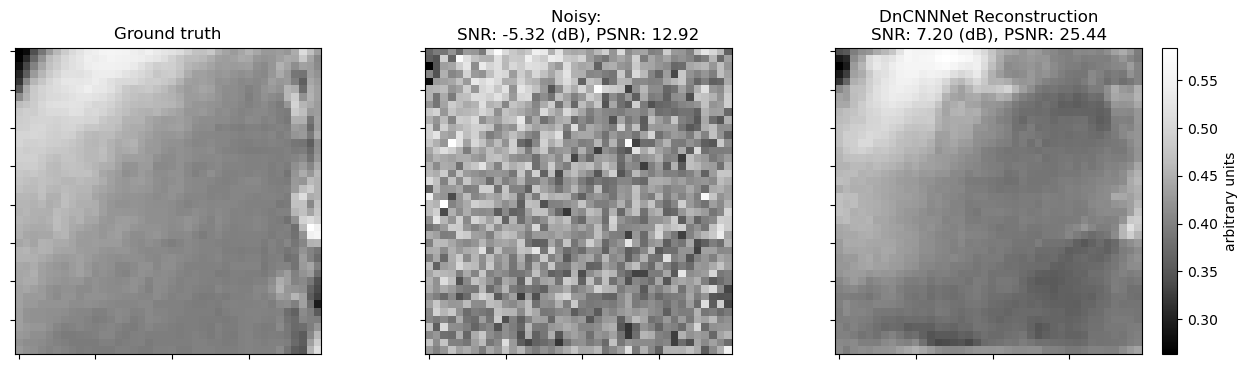

In [8]:
np.random.seed(123)
indx = np.random.randint(0, high=test_patches)

fig, ax = plot.subplots(nrows=1, ncols=3, figsize=(15, 5))
plot.imview(test_ds["label"][indx, ..., 0], title="Ground truth", cbar=None, fig=fig, ax=ax[0])
plot.imview(
    test_ds["image"][indx, ..., 0],
    title="Noisy: \nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], test_ds["image"][indx, ..., 0]),
    ),
    cbar=None,
    fig=fig,
    ax=ax[1],
)
plot.imview(
    output[indx, ..., 0],
    title="DnCNNNet Reconstruction\nSNR: %.2f (dB), PSNR: %.2f"
    % (
        metric.snr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
        metric.psnr(test_ds["label"][indx, ..., 0], output[indx, ..., 0]),
    ),
    fig=fig,
    ax=ax[2],
)
divider = make_axes_locatable(ax[2])
cax = divider.append_axes("right", size="5%", pad=0.2)
fig.colorbar(ax[2].get_images()[0], cax=cax, label="arbitrary units")
fig.show()

Plot convergence statistics. Statistics are generated only if a training
cycle was done (i.e. if not reading final epoch results from checkpoint).

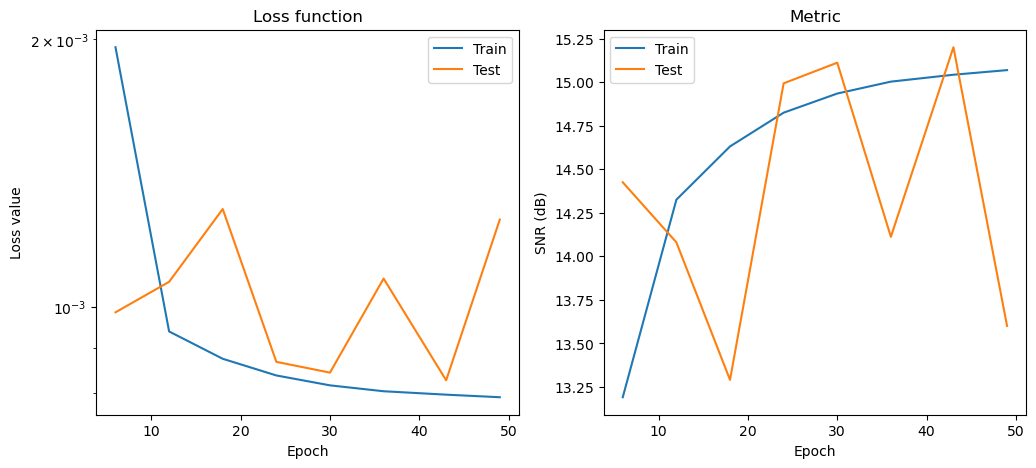

In [9]:
if stats_object is not None and len(stats_object.iterations) > 0:
    hist = stats_object.history(transpose=True)
    fig, ax = plot.subplots(nrows=1, ncols=2, figsize=(12, 5))
    plot.plot(
        np.vstack((hist.Train_Loss, hist.Eval_Loss)).T,
        x=hist.Epoch,
        ptyp="semilogy",
        title="Loss function",
        xlbl="Epoch",
        ylbl="Loss value",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[0],
    )
    plot.plot(
        np.vstack((hist.Train_SNR, hist.Eval_SNR)).T,
        x=hist.Epoch,
        title="Metric",
        xlbl="Epoch",
        ylbl="SNR (dB)",
        lgnd=("Train", "Test"),
        fig=fig,
        ax=ax[1],
    )
    fig.show()